In [ ]:
import re
import urllib
import requests
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
from datetime import datetime
import pandas as pd
import numpy as np

font = fm.FontProperties(fname="C:\Windows\Fonts\malgun.ttf").get_name()
rc('font', family=font)

In [ ]:
"""
# 전체 기사
https://www.boannews.com/media/t_list.asp
# 키워드 검색
https://www.boannews.com/search/news_total.asp?search=title&find=%B7%E7%C6%AE%C5%B6
# 카테고리 분류
https://www.boannews.com/media/s_list.asp?skind=D
# 주중 많이본 뉴스
https://www.boannews.com/media/o_list.asp
"""

In [129]:
class BoanNews:
    # 탐색을 위한 URL 변수들
    trends_url = "https://www.boannews.com/media/o_list.asp"
    keword_url = "https://www.boannews.com/search/news_total.asp"
    # category_url = "https://www.boannews.com/media/s_list.asp"

    # 열람을 위한 URL 변수
    post_url = "https://www.boannews.com/media/view.asp"

    # 탐색 및 열람을 위한 헤더 변수
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.3'
    }

    # 카테고리 확인을 위한 변수
    # category = {
    #     '1': '전체기사',
    #     '2': '오피니언',
    #     '3': '인터뷰',
    #     '4': '기사수첩',
    #     '5': '취약점 경고 및 보안 업데이트',
    #     '6': '정책',
    #     '7': '기획특집',
    #     '8': '기업뉴스',
    #     '9': 'Case Study',
    #     'A': 'Security In Movie',
    #     'B': '행사ㆍ이벤트',
    #     'C': 'TV',
    #     'D': '국제',
    #     'E': '스마트',
    #     'F': '구인구직',
    #     'G': '속보',
    #     'H': '포토뉴스',
    #     'I': '보안ㆍIT산업 동향',
    #     'J': '카드뉴스',
    #     'K': '인사ㆍ부고'
    # }


    ####################################################################################################
    # 데이터 초기화 함수들

    def __init__(self):
        # 탐색 및 열람을 위한 파라미터 변수
        self.params = dict()
        # 탐색한 뉴스리스트를 저장하는 변수
        self.news_list = []
        # 열람한 뉴스게시글을 저장하는 변수
        self.post_text = ""
        # 워드클라우드 및 네트워크 그래프를 만들기 위한 변수
        self.word_list = []


    def clear(self):
        """
        지금까지 사용한 모든 데이터를 삭제한다.
        """
        self.params = dict()
        self.news_list = []
        self.post_text = ""
        self.word_list = []


    ####################################################################################################
    # 파라미터 설정 함수들

    def _set_trends_params(self, page):
        """
        트랜드 뉴스 URL 파리미터를 설정한다.
        """
        self.params = {
            'Page': str(page)
        }
    

    def _set_keword_params(self, keword, page):
        """
        키워드 포함 뉴스 URL 파라미터를 설정한다.
        """
        encrypted_keyword = self._change_keword(keword)
        self.params = {
            'search': 'title',
            'find': encrypted_keyword,
            'Page': str(page)
        }
    

    # def _set_category_params(self, category):
    #     """
    #     카테고리별 뉴스 URL 파라미터를 설정한다.
    #     """
    #     self.params = {
    #         'skind': str(category)
    #     }
    

    def _set_post_params(self, post_index):
        """
        뉴스 게시글 URL 파라미터를 작성한다.
        """
        self.params = {
            'idx': str(post_index)
        }


    ####################################################################################################
    # 데이터 처리 함수들

    def _change_keword(self, keword):
        """
        키워드를 EUC-KR 포멧으로 바꿔준다
        """
        result = keword.encode('euc-kr')

        return result


    def _find_date(self, text):
        """
        텍스트에서 날짜를 찾아 추출한다.
        """
        regex = '[0-2][0-9][0-9][0-9]년 [0-1][0-9]월 [0-3][0-9]일'
        date = re.search(regex, text)

        if date is None:
            return None

        date = date.group()
        
        return date
    

    def _find_post_index(self, url):
        """
        저장된 데이터의 URL에서 게시글 인덱스를 찾아 추출한다.
        """
        regex = 'idx=[0-9]+'
        index = re.search(regex, url)
        index = index.group()
        index = index.replace('idx=','')
        
        return index
    
    
    def _check_date(self, date):
        """
        입력한 날짜 형식이 올바른 검사한다.
        """
        pass
    

    ####################################################################################################
    # 뉴스 탐색용 함수들

    def search_trends(self):
        """
        주중 많이 본 뉴스를 탐색하고 관련 정보를 저장한다.
        """
        # 첫번째 페이지 설정하기
        page = 1
        while True:
            # HTML 문서 받아오기
            self._set_trends_params(page)
            response = requests.get(self.trends_url, headers=self.headers, params=self.params, verify=False)
            
            # 응답코드가 200이 아니면 반복문 종료하기
            if response.status_code != 200:
                break
            
            # 뉴스 데이터 추출하기
            soup = BeautifulSoup(response.text, 'html.parser')
            news_list = soup.select('.news_list')

            if news_list == []:
                break

            for i in range(len(news_list)):
                date = news_list[i].select_one('.news_writer').text
                date = self._find_date(date)
                
                info = news_list[i].select('a')
                
                title = info[0].text.strip()
                title = title.replace(',','.')
                summary = info[1].text.strip()
                summary = summary.replace(',','.')
                url = "boannews.com" + info[0].attrs['href']

                # category = re.search('kind=.*&?', url)
                # category = category.group()
                # category = re.search('[0-9]+', category)
                # category = category.group()
                # category = self.category[category]
                
                tmp_data = {
                    'category' : '주간 인기',
                    'date': date,
                    # 'category' : category,
                    'title': title,
                    'summary': summary,
                    'url': url
                }
                # 뉴스 데이터 저장하기
                self.news_list.append(tmp_data)
                
            # 다음 페이지로 설정하기
            page += 1


    def search_keword(self, keword):
        """
        키워드가 포함된 뉴스를 탐색하고 관련 정보를 저장한다.
        """
        # 첫번째 페이지 설정하기
        page = 1
        while True:
            # HTML 문서 받아오기
            self._set_keword_params(keword, page)
            response = requests.get(self.keword_url, headers=self.headers, params=self.params, verify=False)
            
            # 응답코드가 200이 아니면 반복문 종료하기
            if response.status_code != 200:
                break
            
            # 뉴스 데이터 추출하기
            soup = BeautifulSoup(response.text, 'html.parser')
            news_list = soup.select('.news_list')

            if news_list == []:
                break

            for i in range(len(news_list)):
                date = news_list[i].select_one('.news_writer').text
                date = self._find_date(date)
                
                info = news_list[i].select('a')
                
                title = info[0].text.strip()
                title = title.replace(',','.')
                summary = info[1].text.strip()
                summary = summary.replace(',','.')
                url = "boannews.com" + info[0].attrs['href']

                # category = re.search('kind=.*&?', url)
                # category = category.group()
                # category = re.search('[0-9]+', category)
                # category = category.group()
                # category = self.category[category]
                
                tmp_data = {
                    'category' : f'검색: {keword}',
                    'date': date,
                    # 'category' : category,
                    'title': title,
                    'summary': summary,
                    'url': url
                }
                # 뉴스 데이터 저장하기
                self.news_list.append(tmp_data)
                
            # 다음 페이지로 설정하기
            page += 1


    # def search_category(self, keword):
    #     pass
    
    ####################################################################################################
    # 뉴스 게시글 열람 함수

    def open_post(self, index):
        """
        해당하는 뉴스 게시글의 정보를 가져온다.
        """
        post_index = self._find_post_index(self.news_list[index]['url'])
        self._set_post_params(post_index)
        response = requests.get(self.post_url, headers=self.headers, params=self.params, verify=False)
        tmp_post = BeautifulSoup(response.text, 'html.parser')
        tmp_post = str(tmp_post.select_one('#news_content'))
        tmp_post = str(tmp_post)
        tmp_post = re.sub('\<[^\>]*\>', ' ', tmp_post)
        tmp_post = re.sub('\[[^\]]*\]', ' ', tmp_post)
        tmp_post = re.sub('&.*;', ' ', tmp_post)
        tmp_post = re.sub('저작권자.*', ' ', tmp_post)
        tmp_post = tmp_post.replace('\n', ' ')
        tmp_post = tmp_post.replace('\xa0', ' ')
        tmp_post = re.sub(' +', ' ', tmp_post)
        tmp_post.strip()
        self.post_text += tmp_post


    ####################################################################################################
    # 시각화 함수들

    # def show_news_category(self):
        # data = []
        # for i in range(len(self.news_list)):
        #     data.append(self.news_list[i]['category'])
        # plt.hist(data)
        # plt.show()


    def show_news_timeline(self):
        data = []
        for i in range(len(self.news_list)):
            data.append(self.news_list[i]['date'])
        data = Counter(data)
        date = data.keys()
        freq = data.values()
        plt.xticks(rotation=45)
        plt.plot(date, freq)


    def show_title_include(self, keword):
        yes = 0
        for i in range(len(self.news_list)):
            if keword in self.news_list[i]['title']:
                yes += 1
        no = len(self.news_list) - yes
        data = [yes, no]
        label = ['yes', 'no']
        print(data)
        plt.bar(label, data)
        plt.show()


    # def show_news_network(self):
        
    #     okt = Okt()
    #     dataset = []
    #     for i in range(len(self.news_list)):
    #         dataset.append(okt.nouns(re.sub('가-힣a-zA-Z\s', '', self.news_list[i]['title'])))
    #     result = (list(apriori(dataset, min_support=0.01)))
    #     df=pd.DataFrame(result)
    #     df['length'] = df['items'].apply(lambda x: len(x))
    #     df['length'] = df[(df['length']==2) & (df['support'] >= 0.01)].sort_values(by='support', ascending=False)

    #     G = nx.Graph()
    #     ar = (df['items'])
    #     G.add_edges_from(ar)
    #     pr = nx.pagerank(G)
    #     nsize = np.array([v for v in pr.values()])
    #     nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

    #     post = nx.planar_layout(G)
        
    #     plt.figure(figsize=(16,12)); plt.axis('off')
    #     nx.draw_networkx(G, font_family='KoPubDotum', font_size=16,
    #                      post=pos, node_color=list(pr.values()), node_size=nsize,
    #                      alpha=0.7, edge_color='.5', amap=plt.cm.YIGn)
    

    def show_post_wordcloud(self):
        okt = Okt()
        self.word_list += okt.nouns(self.post_text)
        self.word_list = [word for word in self.word_list if len(word) > 1]
        count = Counter(self.word_list)
        wc = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=250)
        gen = wc.generate_from_frequencies(count)
        plt.figure()
        plt.imshow(gen)
    

    ####################################################################################################
    # 데이터 저장 함수들

    def save_news_list(self):
        """
        지금까지 탐색한 뉴스리스트를 CSV로 저장한다.
        """
        now = datetime.now()
        now = now.strftime('%Y-%m-%d-%H%M%S')
        with open(f'./news_list_{now}.csv', 'w') as f:
            field = ','.join(str(field) for field in self.news_list[0].keys()) + '\n'
            f.write(field)
            record = '\n'.join([','.join(map(str,record.values())) for record in self.news_list]) 
            f.write(record)


    def save_post_text(self):
        """
        지금까지 열람한 뉴스게시글을 TXT로 저장한다.
        """
        now = datetime.now()
        now = now.strftime('%Y-%m-%d-%H%M%S')
        with open(f'./post_text_{now}.txt', 'w') as f:
            f.write(self.post_text)


    # def save_post_wordcloud(self):
    #     pass
    

    ####################################################################################################
    # 사용법 도움말 함수

    # def show_help(self):
    #     bn_help = """
    #         BoanNews는 보안뉴스를 분석하는 클래스입니다. 원하는 게시글을
    #     """
    #     pass
    

c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.boannews.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


[5, 17]


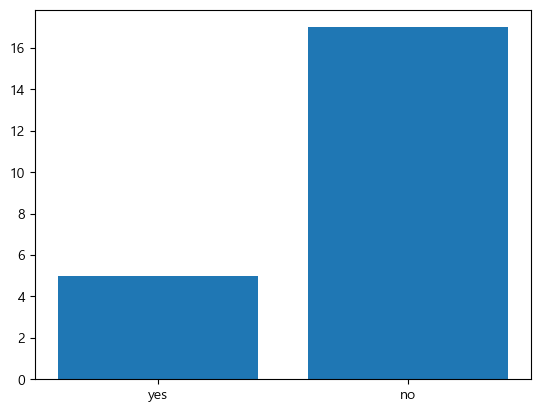

In [130]:
bn = BoanNews()
bn.search_keword('루트킷')
bn.show_title_include('루트킷')

In [128]:
bn.news_list

[{'category': '검색: 루트킷',
  'date': '2022년 09월 28일',
  'title': '北 해커조직 라자루스. 취약한 ‘BYOVD’ 드라이버 이용해 보안 시스템 노렸다',
  'summary': '북한의 해킹그룹으로 알려진 라자루스(LAZARUS)가 최근 취약점을 가진 드라이버를 이용해 기관 등 조직을 공격한 사례를 상세 분석한 보고서가 발표됐다. 안랩(대...',
  'url': 'boannews.com/media/view.asp?idx=110242&page=1&kind=1'},
 {'category': '검색: 루트킷',
  'date': '2022년 07월 22일',
  'title': '새로운 멀웨어 프레임워크. 리눅스 시스템에 루트킷 설치',
  'summary': '현재까지 한 번도 발견되지 않았던 리눅스 멀웨어 프레임워크가 발견됐다고 보안 외신인 해커뉴스가 보도했다. 모듈 구성이며. 각종 루트킷을 설치하는 기능을 가지고 있...',
  'url': 'boannews.com/media/view.asp?idx=108573&page=1&kind=1'},
 {'category': '검색: 루트킷',
  'date': '2021년 10월 21일',
  'title': 'MS 서명 훔친 공격자들. 중국 게이머들의 게임 자원 노린다',
  'summary': '마이크로소프트가 정상적으로 서명한 인증서가 다시 한 번 중국 게이머들 사이에서 문제를 일으키고 있다. 지난 여름에 발생한 사건과 비슷하게. 이번에도 MS가 서명한...',
  'url': 'boannews.com/media/view.asp?idx=101770&page=1&kind=1'},
 {'category': '검색: 루트킷',
  'date': '2019년 09월 18일',
  'title': '리눅스 시스템 집요하게 노리는 암호화폐 채굴 코드. 스키드맵',
  'summary': '리눅스 기반 기계들에 침투하는 암호화폐 채굴 멀웨어가 새롭게 발견됐다. 이름은 스키드맵(S

In [ ]:
bn = BoanNews()
bn.search_trends()
for i in range(len(bn.news_list)):
    bn.open_post(i)
bn.show_post_wordcloud()

In [ ]:
bn2 = BoanNews()
bn2.search_keword('루트킷')
bn2.show_news_timeline()

In [ ]:
bn2.word_list

In [ ]:
bn2.news_list

In [ ]:
bn2.post_text

In [ ]:
bn2.save_news_list()

In [ ]:
bn2.save_post_text()